In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import einops
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import r2_score


### Defining Dataset

In [2]:
'''
For this project, I will be using sequential based nn models (rnn, lstm, gru)
to predict hourly temperatures of the Irish city Galway using previous temperatures
https://www.kaggle.com/datasets/conorrot/irish-weather-hourly-data

'''

df = pd.read_csv("datasets/hrly_Irish_weather.csv", low_memory=False)
print(df.shape)
df.head()

(4660423, 18)


,county,station,latitude,longitude,date,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,sun,vis,clht,clamt
0,Galway,ATHENRY,53.289,-8.786,26-jun-2011 01:00,0.0,15.3,14.5,13.9,15.8,90,1016.0,8,190,NaN,NaN,NaN,NaN
1,Galway,ATHENRY,53.289,-8.786,26-jun-2011 02:00,0.0,14.7,13.7,12.9,14.9,89,1015.8,7,190,NaN,NaN,NaN,NaN
2,Galway,ATHENRY,53.289,-8.786,26-jun-2011 03:00,0.0,14.3,13.4,12.6,14.6,89,1015.5,6,190,NaN,NaN,NaN,NaN
3,Galway,ATHENRY,53.289,-8.786,26-jun-2011 04:00,0.0,14.4,13.6,12.8,14.8,90,1015.3,7,180,NaN,NaN,NaN,NaN
4,Galway,ATHENRY,53.289,-8.786,26-jun-2011 05:00,0.0,14.4,13.5,12.7,14.7,89,1015.1,6,190,NaN,NaN,NaN,NaN


### Proprocessing Dataset

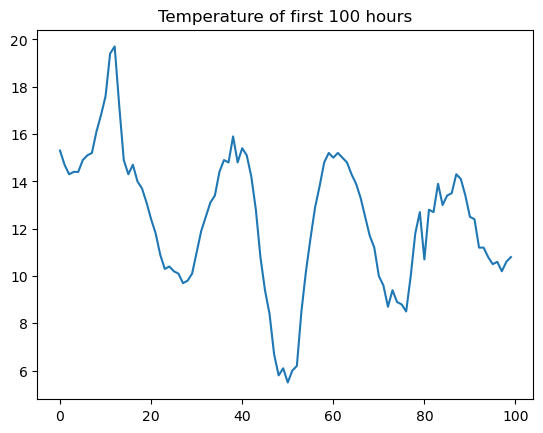

(4214711, 8)


,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp
0,0.0,15.3,14.5,13.9,15.8,90.0,1016.000000,8.0
1,0.0,14.7,13.7,12.9,14.9,89.0,1015.799988,7.0
2,0.0,14.3,13.4,12.6,14.6,89.0,1015.500000,6.0
3,0.0,14.4,13.6,12.8,14.8,90.0,1015.299988,7.0
4,0.0,14.4,13.5,12.7,14.7,89.0,1015.099976,6.0


In [3]:
df = df.drop(["date", "latitude", "longitude", "station", "county", "wddir", "sun", "vis", "clht", "clamt"], axis=1) # droping non numerical columns
# df = df.dropna()
df = df[df != " "] # droping all rows with non numerical values 
df = df.astype("float32")  # converting data to float
df = df.dropna()
df.temp[:100].plot(title="Temperature of first 100 hours") # ploting first 100 hours
plt.show()
irish_data = df.values
print(irish_data.shape)
df.head()

### Extracting features and targets from dataset
The RNN model takes in a sequence with 8 features in each time stamp and outputs a sequence of the same length with 1 output per timestamp. It has a single hidden layer and a dropout layer for regularization. The output of the RNN will be the prediction

In [4]:
class weather_data(Dataset):
    '''
    data: dataset
    seq_len: length of time series
    offset: how much to slide window
    generates sequences of length seq_len with a sliding window 
    '''
    def __init__(self, data, seq_len, offset, train=False):
        super(weather_data, self).__init__()
        sc = MinMaxScaler()
        data = sc.fit_transform(data)
        self.seq_len = seq_len
        self.x = []
        self.y = []
        if(train):
            for i in range(0,data.shape[0]-seq_len, offset): # collecting sequences using sliding window technique
                self.x.append(data[i:i+seq_len])
                self.y.append(data[i+1:i+1+seq_len,1])  
        else:
            for i in range(0,data.shape[0]-seq_len, offset//2):
                self.x.append(data[i:i+seq_len])
                self.y.append(data[i+1:i+1+seq_len,1]) 

        self.x = np.array(self.x)
        self.y = np.array(self.y)
        self.x = torch.tensor(self.x)
        self.y = torch.tensor(self.y)

    def __len__(self):
        '''return len of dataset'''
        return self.x.shape[0]
    def __getitem__(self, idx):
        '''return sequence, future sequence'''
        return self.x[idx], self.y[idx]

### Defining the model
All three variants are created using the same class. The variant of RNN is specified as a parameter

In [5]:
class TIME_SERIES_MODEL(nn.Module):
    def __init__(self, in_feat, hidden_layers, num_layers, out_dim, dropout, network):
        '''
        in_dim: input layer dim
        hidden_layers: hidden layers in lstm
        '''
        super(TIME_SERIES_MODEL, self).__init__()
        if(network == "LSTM"):
            self.time_series_model = nn.LSTM(in_feat, hidden_layers, num_layers, dropout=dropout, batch_first=True)
        elif(network == "GRU"):
            self.time_series_model= nn.GRU(in_feat, hidden_layers, num_layers, dropout=dropout, batch_first=True)
        elif(network == "RNN"):
            self.time_series_model = nn.RNN(in_feat, hidden_layers, num_layers, dropout=dropout, batch_first=True)
        else:
            print("Invalid model type specified, defaulting to RNN")
            self.time_series_model = nn.RNN(in_feat, hidden_layers, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_layers, out_dim)
        self.num_layers = num_layers
        self.hidden_layers = hidden_layers
        self.network = network

    def forward(self, x):
        x, _ = self.time_series_model(x)
        return x

In [6]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")
batch_size = 512
learning_rate = 0.1
max_epochs = 30
in_feat = 8
hidden_dim = 1
num_layers = 1
dropout = .1
seq_len = 1000
offset = 20

rnn_model = TIME_SERIES_MODEL(in_feat, hidden_dim, num_layers, seq_len, dropout, "RNN")
lstm_model = TIME_SERIES_MODEL(in_feat, hidden_dim, num_layers, seq_len, dropout, "LSTM")
gru_model = TIME_SERIES_MODEL(in_feat, hidden_dim, num_layers, seq_len, dropout, "GRU")
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)

# load training data in batches
train_data = irish_data[:int(irish_data.shape[0]*.8)]
valid_data = irish_data[int(irish_data.shape[0]*.8):int(irish_data.shape[0]*.9)]
test_data = irish_data[int(irish_data.shape[0]*.9):]
train_loader = du.DataLoader(dataset=weather_data(train_data, seq_len, offset, True),
                             batch_size=batch_size,
                             shuffle=True)
valid_loader = du.DataLoader(dataset=weather_data(valid_data, seq_len, offset),
                             batch_size=batch_size,
                             shuffle=True)
test_loader = du.DataLoader(dataset=weather_data(test_data, seq_len, offset),
                             batch_size=batch_size,
                             shuffle=False)
# send model over to device
rnn_model = rnn_model.to(device)
lstm_model = lstm_model.to(device)
gru_model = gru_model.to(device)
rnn_model.train()
lstm_model.train()
gru_model.train()

using device: cuda:0


c:\Users\lij47\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


TIME_SERIES_MODEL(
  (time_series_model): GRU(8, 1, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=1, out_features=1000, bias=True)
)

### Training Loop
All the models are trained at the same time.

R2 score is the evaluation metric because the target is continuous. MSE can also be used as an evaluation metric but mse is used as the loss function so I chose to use a different evaluation metric to better capture the performance of the models.

In [7]:
rnn_train_loss_list = []
rnn_valid_loss_list = []
lstm_train_loss_list = []
lstm_valid_loss_list = []
gru_train_loss_list = []
gru_valid_loss_list = []
rnn_train_r2_list = []
lstm_train_r2_list = []
gru_train_r2_list = []
rnn_valid_r2_list = []
lstm_valid_r2_list = []
gru_valid_r2_list = []
# iterating through all epochs
for epoch in range(1, max_epochs + 1):    
    # training step
    rnn_train_loss = 0.
    lstm_train_loss = 0.
    gru_train_loss = 0.
    rnn_model.train()
    lstm_model.train()
    gru_model.train()
    epoch_rnn_train_r2_list = []
    epoch_lstm_train_r2_list = []
    epoch_gru_train_r2_list = []
    # iterating through entire dataset in batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # sending batch over to device
        data, target = data.to(device), target.to(device)
        # zeroing out previous gradients
        rnn_optimizer.zero_grad()
        lstm_optimizer.zero_grad()
        gru_optimizer.zero_grad()
        # getting predictions from model
        rnn_pred = rnn_model(data).squeeze(dim=-1)
        lstm_pred = lstm_model(data).squeeze(dim=-1)
        gru_pred = gru_model(data).squeeze(dim=-1)
        # claculating mse loss
        rnn_loss = F.mse_loss(rnn_pred, target)
        lstm_loss = F.mse_loss(lstm_pred, target)
        gru_loss = F.mse_loss(gru_pred, target)
        rnn_train_loss += rnn_loss.item()
        lstm_train_loss += lstm_loss.item()
        gru_train_loss += gru_loss.item()
        # backprop
        rnn_loss.backward()
        lstm_loss.backward()
        gru_loss.backward()
        rnn_optimizer.step()
        lstm_optimizer.step()
        gru_optimizer.step()
        epoch_rnn_train_r2_list.append(r2_score(target.detach().cpu().numpy(), rnn_pred.detach().cpu().numpy()))
        epoch_lstm_train_r2_list.append(r2_score(target.detach().cpu().numpy(), lstm_pred.detach().cpu().numpy()))
        epoch_gru_train_r2_list.append(r2_score(target.detach().cpu().numpy(), gru_pred.detach().cpu().numpy()))
    
    # validation step
    rnn_valid_loss = 0
    lstm_valid_loss = 0
    gru_valid_loss = 0
    epoch_rnn_valid_r2_list = []
    epoch_lstm_valid_r2_list = []
    epoch_gru_valid_r2_list = []
    # turning off grad for validation step
    rnn_model.eval()
    lstm_model.eval()
    gru_model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(valid_loader)):
            data, target = data.to(device), target.to(device)
            rnn_pred = rnn_model(data).squeeze(dim=-1)
            lstm_pred = lstm_model(data).squeeze(dim=-1)
            gru_pred = gru_model(data).squeeze(dim=-1)
            rnn_loss = F.mse_loss(rnn_pred, target)
            lstm_loss = F.mse_loss(lstm_pred, target)
            gru_loss = F.mse_loss(gru_pred, target)
            rnn_valid_loss += rnn_loss.item()
            lstm_valid_loss += lstm_loss.item()
            gru_valid_loss += gru_loss.item()
            epoch_rnn_valid_r2_list.append(r2_score(target.detach().cpu().numpy(), rnn_pred.detach().cpu().numpy()))
            epoch_lstm_valid_r2_list.append(r2_score(target.detach().cpu().numpy(), lstm_pred.detach().cpu().numpy()))
            epoch_gru_valid_r2_list.append(r2_score(target.detach().cpu().numpy(), gru_pred.detach().cpu().numpy()))
            
    # calculating average loss
    rnn_train_loss /= len(train_loader.dataset)
    lstm_train_loss /= len(train_loader.dataset)
    gru_train_loss /= len(train_loader.dataset)
    rnn_valid_loss /= len(valid_loader.dataset)
    lstm_valid_loss /= len(valid_loader.dataset)
    gru_valid_loss /= len(valid_loader.dataset)
    rnn_train_r2_score = sum(epoch_rnn_train_r2_list) / len(epoch_rnn_train_r2_list)
    lstm_train_r2_score = sum(epoch_lstm_train_r2_list) / len(epoch_lstm_train_r2_list)
    gru_train_r2_score = sum(epoch_gru_train_r2_list) / len(epoch_gru_train_r2_list)
    rnn_valid_r2_score = sum(epoch_rnn_valid_r2_list) / len(epoch_rnn_valid_r2_list)
    lstm_valid_r2_score = sum(epoch_lstm_valid_r2_list) / len(epoch_lstm_valid_r2_list)
    gru_valid_r2_score = sum(epoch_gru_valid_r2_list) / len(epoch_gru_valid_r2_list)
    rnn_train_loss_list.append(rnn_train_loss)
    lstm_train_loss_list.append(lstm_train_loss)
    gru_train_loss_list.append(gru_train_loss)
    rnn_valid_loss_list.append(rnn_valid_loss)
    lstm_valid_loss_list.append(lstm_valid_loss)
    gru_valid_loss_list.append(gru_valid_loss)
    rnn_train_r2_list.append(rnn_train_r2_score)
    lstm_train_r2_list.append(lstm_train_r2_score)
    gru_train_r2_list.append(gru_train_r2_score)
    rnn_valid_r2_list.append(rnn_valid_r2_score)
    lstm_valid_r2_list.append(lstm_valid_r2_score)
    gru_valid_r2_list.append(gru_valid_r2_score)

    # printing loss per epoch
    print(f'RNN Epoch: {epoch}, Train Loss: {rnn_train_loss:.10f}, R2 Train Score: {rnn_train_r2_score:.3f}, Valid Loss: {rnn_valid_loss:.10f}, R2 Valid Score: {rnn_valid_r2_score:.3f}')
    print(f'LSTM Epoch: {epoch}, Train Loss: {lstm_train_loss:.10f}, R2 Train Score: {lstm_train_r2_score:.3f}, Valid Loss: {lstm_valid_loss:.10f}, R2 Valid Score: {lstm_valid_r2_score:.3f}')
    print(f'GRU Epoch: {epoch}, Train Loss: {gru_train_loss:.10f}, R2 Train Score: {gru_train_r2_score:.3f}, Valid Loss: {gru_valid_loss:.10f}, R2 Valid Score: {gru_valid_r2_score:.3f}')

100%|██████████| 83/83 [00:05<00:00, 14.90it/s]


RNN Epoch: 1, Train Loss: 0.0000046799, R2 Train Score: 0.767, Valid Loss: 0.0000187718, R2 Valid Score: 0.147
LSTM Epoch: 1, Train Loss: 0.0000033062, R2 Train Score: 0.834, Valid Loss: 0.0000118006, R2 Valid Score: 0.463
GRU Epoch: 1, Train Loss: 0.0000035072, R2 Train Score: 0.825, Valid Loss: 0.0000091564, R2 Valid Score: 0.585


100%|██████████| 83/83 [00:05<00:00, 14.78it/s]


RNN Epoch: 2, Train Loss: 0.0000007305, R2 Train Score: 0.964, Valid Loss: 0.0000198219, R2 Valid Score: 0.098
LSTM Epoch: 2, Train Loss: 0.0000007067, R2 Train Score: 0.965, Valid Loss: 0.0000085297, R2 Valid Score: 0.612
GRU Epoch: 2, Train Loss: 0.0000006922, R2 Train Score: 0.965, Valid Loss: 0.0000091399, R2 Valid Score: 0.585


100%|██████████| 83/83 [00:05<00:00, 14.70it/s]


RNN Epoch: 3, Train Loss: 0.0000008565, R2 Train Score: 0.957, Valid Loss: 0.0000173595, R2 Valid Score: 0.211
LSTM Epoch: 3, Train Loss: 0.0000006535, R2 Train Score: 0.967, Valid Loss: 0.0000069623, R2 Valid Score: 0.683
GRU Epoch: 3, Train Loss: 0.0000006621, R2 Train Score: 0.967, Valid Loss: 0.0000085701, R2 Valid Score: 0.611


100%|██████████| 83/83 [00:05<00:00, 14.62it/s]


RNN Epoch: 4, Train Loss: 0.0000008695, R2 Train Score: 0.956, Valid Loss: 0.0000105914, R2 Valid Score: 0.519
LSTM Epoch: 4, Train Loss: 0.0000006241, R2 Train Score: 0.969, Valid Loss: 0.0000053431, R2 Valid Score: 0.757
GRU Epoch: 4, Train Loss: 0.0000006347, R2 Train Score: 0.968, Valid Loss: 0.0000089107, R2 Valid Score: 0.596


100%|██████████| 83/83 [00:05<00:00, 14.54it/s]


RNN Epoch: 5, Train Loss: 0.0000008870, R2 Train Score: 0.956, Valid Loss: 0.0000188606, R2 Valid Score: 0.140
LSTM Epoch: 5, Train Loss: 0.0000006056, R2 Train Score: 0.970, Valid Loss: 0.0000042294, R2 Valid Score: 0.807
GRU Epoch: 5, Train Loss: 0.0000006110, R2 Train Score: 0.969, Valid Loss: 0.0000064097, R2 Valid Score: 0.708


100%|██████████| 83/83 [00:05<00:00, 14.67it/s]


RNN Epoch: 6, Train Loss: 0.0000008198, R2 Train Score: 0.959, Valid Loss: 0.0000163792, R2 Valid Score: 0.255
LSTM Epoch: 6, Train Loss: 0.0000005925, R2 Train Score: 0.970, Valid Loss: 0.0000032848, R2 Valid Score: 0.851
GRU Epoch: 6, Train Loss: 0.0000006056, R2 Train Score: 0.970, Valid Loss: 0.0000071283, R2 Valid Score: 0.676


100%|██████████| 83/83 [00:05<00:00, 14.59it/s]


RNN Epoch: 7, Train Loss: 0.0000008599, R2 Train Score: 0.957, Valid Loss: 0.0000162490, R2 Valid Score: 0.260
LSTM Epoch: 7, Train Loss: 0.0000005843, R2 Train Score: 0.971, Valid Loss: 0.0000023035, R2 Valid Score: 0.895
GRU Epoch: 7, Train Loss: 0.0000006074, R2 Train Score: 0.970, Valid Loss: 0.0000076051, R2 Valid Score: 0.654


100%|██████████| 83/83 [00:05<00:00, 14.38it/s]


RNN Epoch: 8, Train Loss: 0.0000008871, R2 Train Score: 0.956, Valid Loss: 0.0000132503, R2 Valid Score: 0.398
LSTM Epoch: 8, Train Loss: 0.0000005949, R2 Train Score: 0.970, Valid Loss: 0.0000017378, R2 Valid Score: 0.921
GRU Epoch: 8, Train Loss: 0.0000005676, R2 Train Score: 0.972, Valid Loss: 0.0000054672, R2 Valid Score: 0.752


100%|██████████| 83/83 [00:05<00:00, 14.27it/s]


RNN Epoch: 9, Train Loss: 0.0000008506, R2 Train Score: 0.957, Valid Loss: 0.0000156514, R2 Valid Score: 0.287
LSTM Epoch: 9, Train Loss: 0.0000005887, R2 Train Score: 0.971, Valid Loss: 0.0000021486, R2 Valid Score: 0.902
GRU Epoch: 9, Train Loss: 0.0000005617, R2 Train Score: 0.972, Valid Loss: 0.0000052821, R2 Valid Score: 0.760


100%|██████████| 83/83 [00:05<00:00, 14.20it/s]


RNN Epoch: 10, Train Loss: 0.0000008814, R2 Train Score: 0.956, Valid Loss: 0.0000164619, R2 Valid Score: 0.251
LSTM Epoch: 10, Train Loss: 0.0000005875, R2 Train Score: 0.971, Valid Loss: 0.0000010744, R2 Valid Score: 0.951
GRU Epoch: 10, Train Loss: 0.0000005687, R2 Train Score: 0.972, Valid Loss: 0.0000060814, R2 Valid Score: 0.723


100%|██████████| 83/83 [00:05<00:00, 14.22it/s]


RNN Epoch: 11, Train Loss: 0.0000008540, R2 Train Score: 0.957, Valid Loss: 0.0000148451, R2 Valid Score: 0.325
LSTM Epoch: 11, Train Loss: 0.0000005908, R2 Train Score: 0.970, Valid Loss: 0.0000010554, R2 Valid Score: 0.952
GRU Epoch: 11, Train Loss: 0.0000005696, R2 Train Score: 0.972, Valid Loss: 0.0000051519, R2 Valid Score: 0.766


100%|██████████| 83/83 [00:05<00:00, 14.57it/s]


RNN Epoch: 12, Train Loss: 0.0000008945, R2 Train Score: 0.955, Valid Loss: 0.0000083793, R2 Valid Score: 0.618
LSTM Epoch: 12, Train Loss: 0.0000005883, R2 Train Score: 0.971, Valid Loss: 0.0000008355, R2 Valid Score: 0.962
GRU Epoch: 12, Train Loss: 0.0000005606, R2 Train Score: 0.972, Valid Loss: 0.0000043534, R2 Valid Score: 0.802


100%|██████████| 83/83 [00:05<00:00, 14.58it/s]


RNN Epoch: 13, Train Loss: 0.0000008317, R2 Train Score: 0.958, Valid Loss: 0.0000160382, R2 Valid Score: 0.270
LSTM Epoch: 13, Train Loss: 0.0000005863, R2 Train Score: 0.971, Valid Loss: 0.0000012478, R2 Valid Score: 0.943
GRU Epoch: 13, Train Loss: 0.0000005620, R2 Train Score: 0.972, Valid Loss: 0.0000027928, R2 Valid Score: 0.873


100%|██████████| 83/83 [00:05<00:00, 14.53it/s]


RNN Epoch: 14, Train Loss: 0.0000008299, R2 Train Score: 0.959, Valid Loss: 0.0000134103, R2 Valid Score: 0.389
LSTM Epoch: 14, Train Loss: 0.0000005874, R2 Train Score: 0.971, Valid Loss: 0.0000007817, R2 Valid Score: 0.964
GRU Epoch: 14, Train Loss: 0.0000005595, R2 Train Score: 0.972, Valid Loss: 0.0000042790, R2 Valid Score: 0.805


100%|██████████| 83/83 [00:05<00:00, 14.64it/s]


RNN Epoch: 15, Train Loss: 0.0000008591, R2 Train Score: 0.957, Valid Loss: 0.0000208452, R2 Valid Score: 0.051
LSTM Epoch: 15, Train Loss: 0.0000005847, R2 Train Score: 0.971, Valid Loss: 0.0000007589, R2 Valid Score: 0.965
GRU Epoch: 15, Train Loss: 0.0000005662, R2 Train Score: 0.972, Valid Loss: 0.0000039994, R2 Valid Score: 0.818


100%|██████████| 83/83 [00:05<00:00, 14.77it/s]


RNN Epoch: 16, Train Loss: 0.0000008393, R2 Train Score: 0.958, Valid Loss: 0.0000137994, R2 Valid Score: 0.371
LSTM Epoch: 16, Train Loss: 0.0000005825, R2 Train Score: 0.971, Valid Loss: 0.0000007893, R2 Valid Score: 0.964
GRU Epoch: 16, Train Loss: 0.0000005494, R2 Train Score: 0.973, Valid Loss: 0.0000037436, R2 Valid Score: 0.830


100%|██████████| 83/83 [00:05<00:00, 14.85it/s]


RNN Epoch: 17, Train Loss: 0.0000009081, R2 Train Score: 0.955, Valid Loss: 0.0000146187, R2 Valid Score: 0.335
LSTM Epoch: 17, Train Loss: 0.0000005870, R2 Train Score: 0.971, Valid Loss: 0.0000008477, R2 Valid Score: 0.961
GRU Epoch: 17, Train Loss: 0.0000005576, R2 Train Score: 0.972, Valid Loss: 0.0000034841, R2 Valid Score: 0.842


100%|██████████| 83/83 [00:05<00:00, 14.63it/s]


RNN Epoch: 18, Train Loss: 0.0000009199, R2 Train Score: 0.954, Valid Loss: 0.0000128615, R2 Valid Score: 0.414
LSTM Epoch: 18, Train Loss: 0.0000005810, R2 Train Score: 0.971, Valid Loss: 0.0000009853, R2 Valid Score: 0.955
GRU Epoch: 18, Train Loss: 0.0000005553, R2 Train Score: 0.972, Valid Loss: 0.0000030748, R2 Valid Score: 0.860


100%|██████████| 83/83 [00:05<00:00, 14.40it/s]


RNN Epoch: 19, Train Loss: 0.0000008915, R2 Train Score: 0.956, Valid Loss: 0.0000107307, R2 Valid Score: 0.512
LSTM Epoch: 19, Train Loss: 0.0000005835, R2 Train Score: 0.971, Valid Loss: 0.0000008212, R2 Valid Score: 0.963
GRU Epoch: 19, Train Loss: 0.0000005547, R2 Train Score: 0.972, Valid Loss: 0.0000033373, R2 Valid Score: 0.848


100%|██████████| 83/83 [00:05<00:00, 14.39it/s]


RNN Epoch: 20, Train Loss: 0.0000008344, R2 Train Score: 0.958, Valid Loss: 0.0000133175, R2 Valid Score: 0.393
LSTM Epoch: 20, Train Loss: 0.0000005857, R2 Train Score: 0.971, Valid Loss: 0.0000008001, R2 Valid Score: 0.964
GRU Epoch: 20, Train Loss: 0.0000005495, R2 Train Score: 0.973, Valid Loss: 0.0000033983, R2 Valid Score: 0.845


100%|██████████| 83/83 [00:05<00:00, 14.66it/s]


RNN Epoch: 21, Train Loss: 0.0000008115, R2 Train Score: 0.959, Valid Loss: 0.0000129583, R2 Valid Score: 0.410
LSTM Epoch: 21, Train Loss: 0.0000005814, R2 Train Score: 0.971, Valid Loss: 0.0000006550, R2 Valid Score: 0.970
GRU Epoch: 21, Train Loss: 0.0000005480, R2 Train Score: 0.973, Valid Loss: 0.0000023897, R2 Valid Score: 0.891


100%|██████████| 83/83 [00:05<00:00, 14.67it/s]


RNN Epoch: 22, Train Loss: 0.0000008446, R2 Train Score: 0.958, Valid Loss: 0.0000108888, R2 Valid Score: 0.503
LSTM Epoch: 22, Train Loss: 0.0000005832, R2 Train Score: 0.971, Valid Loss: 0.0000008392, R2 Valid Score: 0.962
GRU Epoch: 22, Train Loss: 0.0000005523, R2 Train Score: 0.972, Valid Loss: 0.0000031095, R2 Valid Score: 0.858


100%|██████████| 83/83 [00:05<00:00, 14.86it/s]


RNN Epoch: 23, Train Loss: 0.0000008721, R2 Train Score: 0.956, Valid Loss: 0.0000119693, R2 Valid Score: 0.456
LSTM Epoch: 23, Train Loss: 0.0000005855, R2 Train Score: 0.971, Valid Loss: 0.0000006501, R2 Valid Score: 0.970
GRU Epoch: 23, Train Loss: 0.0000005467, R2 Train Score: 0.973, Valid Loss: 0.0000019616, R2 Valid Score: 0.911


100%|██████████| 83/83 [00:05<00:00, 14.77it/s]


RNN Epoch: 24, Train Loss: 0.0000008072, R2 Train Score: 0.960, Valid Loss: 0.0000119324, R2 Valid Score: 0.457
LSTM Epoch: 24, Train Loss: 0.0000005833, R2 Train Score: 0.971, Valid Loss: 0.0000005604, R2 Valid Score: 0.975
GRU Epoch: 24, Train Loss: 0.0000005498, R2 Train Score: 0.973, Valid Loss: 0.0000027632, R2 Valid Score: 0.874


100%|██████████| 83/83 [00:05<00:00, 14.61it/s]


RNN Epoch: 25, Train Loss: 0.0000008835, R2 Train Score: 0.956, Valid Loss: 0.0000081828, R2 Valid Score: 0.627
LSTM Epoch: 25, Train Loss: 0.0000005804, R2 Train Score: 0.971, Valid Loss: 0.0000009425, R2 Valid Score: 0.957
GRU Epoch: 25, Train Loss: 0.0000005488, R2 Train Score: 0.973, Valid Loss: 0.0000029596, R2 Valid Score: 0.865


100%|██████████| 83/83 [00:05<00:00, 14.77it/s]


RNN Epoch: 26, Train Loss: 0.0000008606, R2 Train Score: 0.957, Valid Loss: 0.0000111609, R2 Valid Score: 0.492
LSTM Epoch: 26, Train Loss: 0.0000005851, R2 Train Score: 0.971, Valid Loss: 0.0000006291, R2 Valid Score: 0.971
GRU Epoch: 26, Train Loss: 0.0000005444, R2 Train Score: 0.973, Valid Loss: 0.0000024598, R2 Valid Score: 0.888


100%|██████████| 83/83 [00:05<00:00, 14.39it/s]


RNN Epoch: 27, Train Loss: 0.0000008679, R2 Train Score: 0.957, Valid Loss: 0.0000096101, R2 Valid Score: 0.562
LSTM Epoch: 27, Train Loss: 0.0000005816, R2 Train Score: 0.971, Valid Loss: 0.0000005381, R2 Valid Score: 0.975
GRU Epoch: 27, Train Loss: 0.0000005459, R2 Train Score: 0.973, Valid Loss: 0.0000030622, R2 Valid Score: 0.860


100%|██████████| 83/83 [00:05<00:00, 14.15it/s]


RNN Epoch: 28, Train Loss: 0.0000008153, R2 Train Score: 0.959, Valid Loss: 0.0000110717, R2 Valid Score: 0.496
LSTM Epoch: 28, Train Loss: 0.0000005811, R2 Train Score: 0.971, Valid Loss: 0.0000005498, R2 Valid Score: 0.975
GRU Epoch: 28, Train Loss: 0.0000005450, R2 Train Score: 0.973, Valid Loss: 0.0000023268, R2 Valid Score: 0.894


100%|██████████| 83/83 [00:05<00:00, 14.35it/s]


RNN Epoch: 29, Train Loss: 0.0000008699, R2 Train Score: 0.957, Valid Loss: 0.0000112650, R2 Valid Score: 0.488
LSTM Epoch: 29, Train Loss: 0.0000005833, R2 Train Score: 0.971, Valid Loss: 0.0000006111, R2 Valid Score: 0.972
GRU Epoch: 29, Train Loss: 0.0000005455, R2 Train Score: 0.973, Valid Loss: 0.0000028949, R2 Valid Score: 0.868


100%|██████████| 83/83 [00:05<00:00, 14.39it/s]

RNN Epoch: 30, Train Loss: 0.0000008469, R2 Train Score: 0.958, Valid Loss: 0.0000135494, R2 Valid Score: 0.382
LSTM Epoch: 30, Train Loss: 0.0000005849, R2 Train Score: 0.971, Valid Loss: 0.0000007118, R2 Valid Score: 0.968
GRU Epoch: 30, Train Loss: 0.0000005446, R2 Train Score: 0.973, Valid Loss: 0.0000026964, R2 Valid Score: 0.877


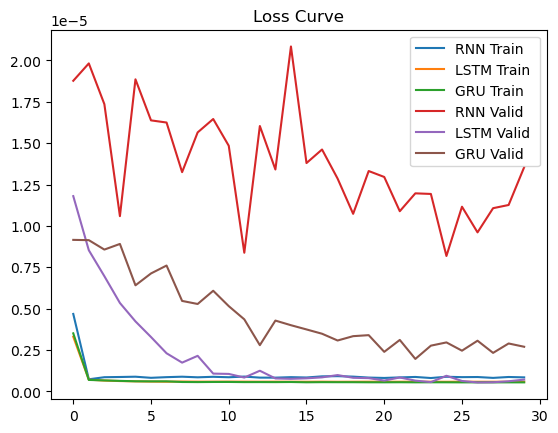

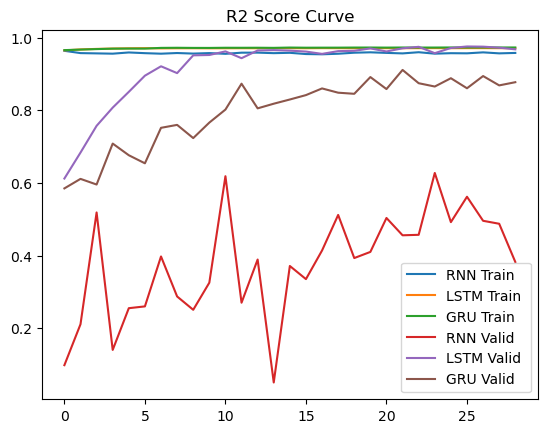

In [8]:
plt.plot(rnn_train_loss_list, label="RNN Train")
plt.plot(lstm_train_loss_list, label="LSTM Train")
plt.plot(gru_train_loss_list, label="GRU Train")
plt.plot(rnn_valid_loss_list, label="RNN Valid")
plt.plot(lstm_valid_loss_list, label="LSTM Valid ")
plt.plot(gru_valid_loss_list, label="GRU Valid")
plt.title("Loss Curve")
plt.legend()
plt.show()
plt.plot(rnn_train_r2_list[1:], label="RNN Train") # removing first epoch because it will mess up the scale
plt.plot(lstm_train_r2_list[1:], label="LSTM Train")
plt.plot(gru_train_r2_list[1:], label="GRU Train")
plt.plot(rnn_valid_r2_list[1:], label="RNN Valid")
plt.plot(lstm_valid_r2_list[1:], label="LSTM Valid ")
plt.plot(gru_valid_r2_list[1:], label="GRU Valid")
plt.title("R2 Score Curve")
plt.legend()
plt.show()

In [9]:
# testing step
rnn_test_loss = 0
lstm_test_loss = 0
gru_test_loss = 0
rnn_test_r2_list = []
lstm_test_r2_list = []
gru_test_r2_list = []
# turning off grad for testing step
rnn_model.eval()
lstm_model.eval()
gru_model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)
        rnn_pred = rnn_model(data).squeeze(dim=-1)
        lstm_pred = lstm_model(data).squeeze(dim=-1)
        gru_pred = gru_model(data).squeeze(dim=-1)
        rnn_loss = F.mse_loss(rnn_pred, target)
        lstm_loss = F.mse_loss(lstm_pred, target)
        gru_loss = F.mse_loss(gru_pred, target)
        rnn_test_loss += rnn_loss.item()
        lstm_test_loss += lstm_loss.item()
        gru_test_loss += gru_loss.item()
        rnn_test_r2_list.append(r2_score(target.detach().cpu().numpy(), rnn_pred.detach().cpu().numpy()))
        lstm_test_r2_list.append(r2_score(target.detach().cpu().numpy(), lstm_pred.detach().cpu().numpy()))
        gru_test_r2_list.append(r2_score(target.detach().cpu().numpy(), gru_pred.detach().cpu().numpy()))
        if(batch_idx == 0):
            rnn_prediction = rnn_pred
            lstm_prediction = lstm_pred
            gru_prediction = gru_pred
            actual = target

        
# calculating average loss
rnn_test_loss /= len(test_loader.dataset)
lstm_test_loss /= len(test_loader.dataset)
gru_test_loss /= len(test_loader.dataset)
rnn_test_r2_score = sum(rnn_test_r2_list) / len(rnn_test_r2_list)
lstm_test_r2_score = sum(lstm_test_r2_list) / len(lstm_test_r2_list)
gru_test_r2_score = sum(gru_test_r2_list) / len(gru_test_r2_list)

# printing loss per epoch
print(f'RNN Test Loss: {rnn_test_loss:.10f}, R2 test Score: {rnn_test_r2_score:.3f}')
print(f'LSTM Test Loss: {lstm_test_loss:.10f}, R2 test Score: {lstm_test_r2_score:.3f}')
print(f'GRU Test Loss: {gru_test_loss:.10f}, R2 test Score: {gru_test_r2_score:.3f}')

100%|██████████| 83/83 [00:05<00:00, 14.33it/s]

RNN Test Loss: 0.0000117501, R2 test Score: 0.293
LSTM Test Loss: 0.0000009128, R2 test Score: 0.946
GRU Test Loss: 0.0000015884, R2 test Score: 0.906


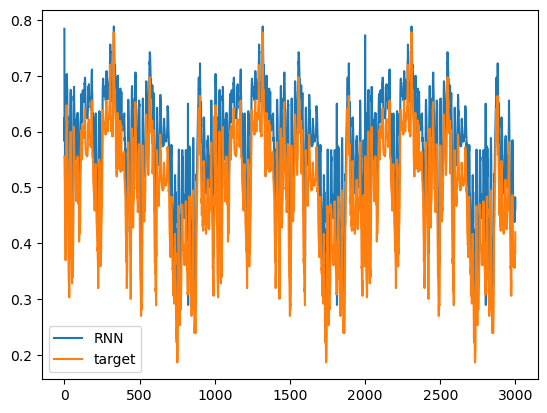

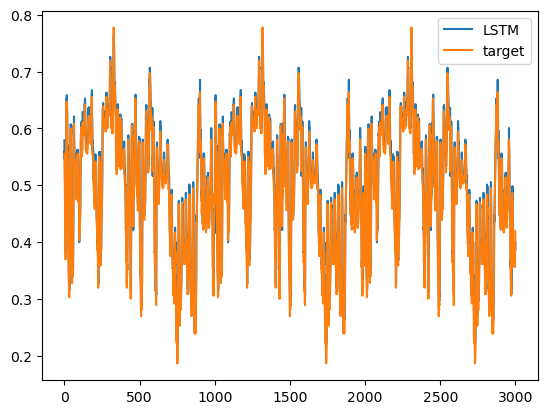

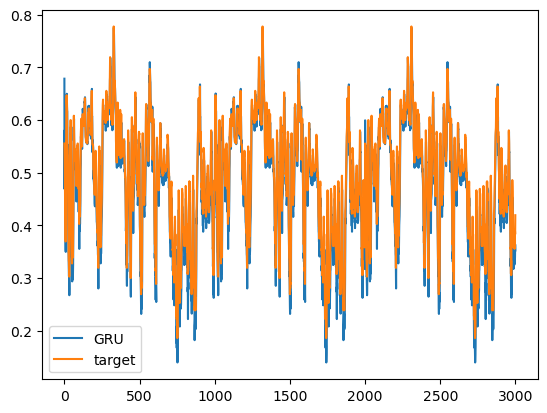

In [10]:
rnn_prediction = rnn_prediction.reshape(-1).detach().cpu().numpy()[:3000]
lstm_prediction = lstm_prediction.reshape(-1).detach().cpu().numpy()[:3000]
gru_prediction = gru_prediction.reshape(-1).detach().cpu().numpy()[:3000]
actual = actual.reshape(-1).detach().cpu().numpy()[:3000]
plt.plot(rnn_prediction, label="RNN")
plt.plot(actual, label="target")
plt.legend()
plt.show()
plt.plot(lstm_prediction, label="LSTM")
plt.plot(actual, label="target")
plt.legend()
plt.show()
plt.plot(gru_prediction, label="GRU")
plt.plot(actual, label="target")
plt.legend()
plt.show()

### Write Up 

Comparing the results from the testing dataset, LSTM and GRU both performed very well while RNN had a much lower accuracy. In addition, LSTM and GRU had smoother training, which is indicated by the smoother loss and R2 curve and faster convergence. While RNN had unstable training. From the plot of the predictions and the targets, we can see that all of the models are able to predict the temperatures pretty well, but LSTM and GRU are able to fit the line better. The reason for this is because LSTM and GRU's have gates which allow them to store information from previous timestamps better than RNNS. This makes sense because a common problem with RNNs is that they have a hard time remembering previous timestamps because there isnt specific mechanisms for it. On the other hand, LSTM's and GRU's are specifically designed to mitigate this shortcomming with the cell state which allows it to figure out what information from previous time stamps is important to keep.

A traditional neural network can be used to solve a similar task to what I performed by adding positional encoding to the data. RNNs are good for time series data because the models explicitly use previous time stamps as part of the prediction of future timestamps. By adding positional encoding, the mlp can learn to weigh previous timestamps of close procximity to predict future timestamps. This techinique might be finicky and require alot of parameter tuning to work but it should be possible. 